In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import csv
import warnings
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical

N = 20

Using TensorFlow backend.
/home/jesse/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jesse/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jesse/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jesse/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [57]:
%matplotlib inline

In [2]:
#hide all warnings
#warnings.filterwarnings('ignore')

#show all warnings just once
warnings.filterwarnings(action='once')

In [3]:
from helpers import data_loader, delete_nans_graph, get_returns, plot_example_returns, tickers, get_data_subsets

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Download Data

In [4]:
begin = "2015-01-01"
finish = "2017-01-01"

data_loader(begin, finish, 'returns.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DOW: Data doesn't exist for startDate = 1420066800, endDate = 1483225200
[*********************100%***********************]  1 of 1 completed
[*******

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SYMC: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********

In [5]:
returns = get_returns('data/returns.csv', N)

Number of columns with only NaNs: 0
Number of lines with only NaNs: 0
Number of NaNs: 0
shape Dataframe: (123, 20)


## Helper Functions

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN
Date,,,,,,,,,,,,,,,,,,,,
2017-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,0.001525,0.007865,0.014221,0.030082,0.002348,0.019755,0.006378,0.000000,0.008191,-0.008763,0.024801,0.009142,0.013228,0.008726,0.011248,0.013391,0.030065,0.025284,0.036533,0.008354
2017-01-05,-0.003411,0.008611,0.007550,-0.008035,-0.014955,0.015553,0.016996,-0.016623,-0.000701,-0.012770,-0.012238,-0.006560,-0.011967,-0.009919,0.017855,-0.015952,-0.003346,-0.003537,0.094957,-0.030173
2017-01-06,0.002933,0.027215,0.000357,0.005313,0.011432,-0.000806,0.022566,0.007117,-0.013044,0.035821,-0.002227,0.003459,0.031050,0.007984,0.003451,-0.008831,0.004630,-0.006811,0.031829,-0.007804


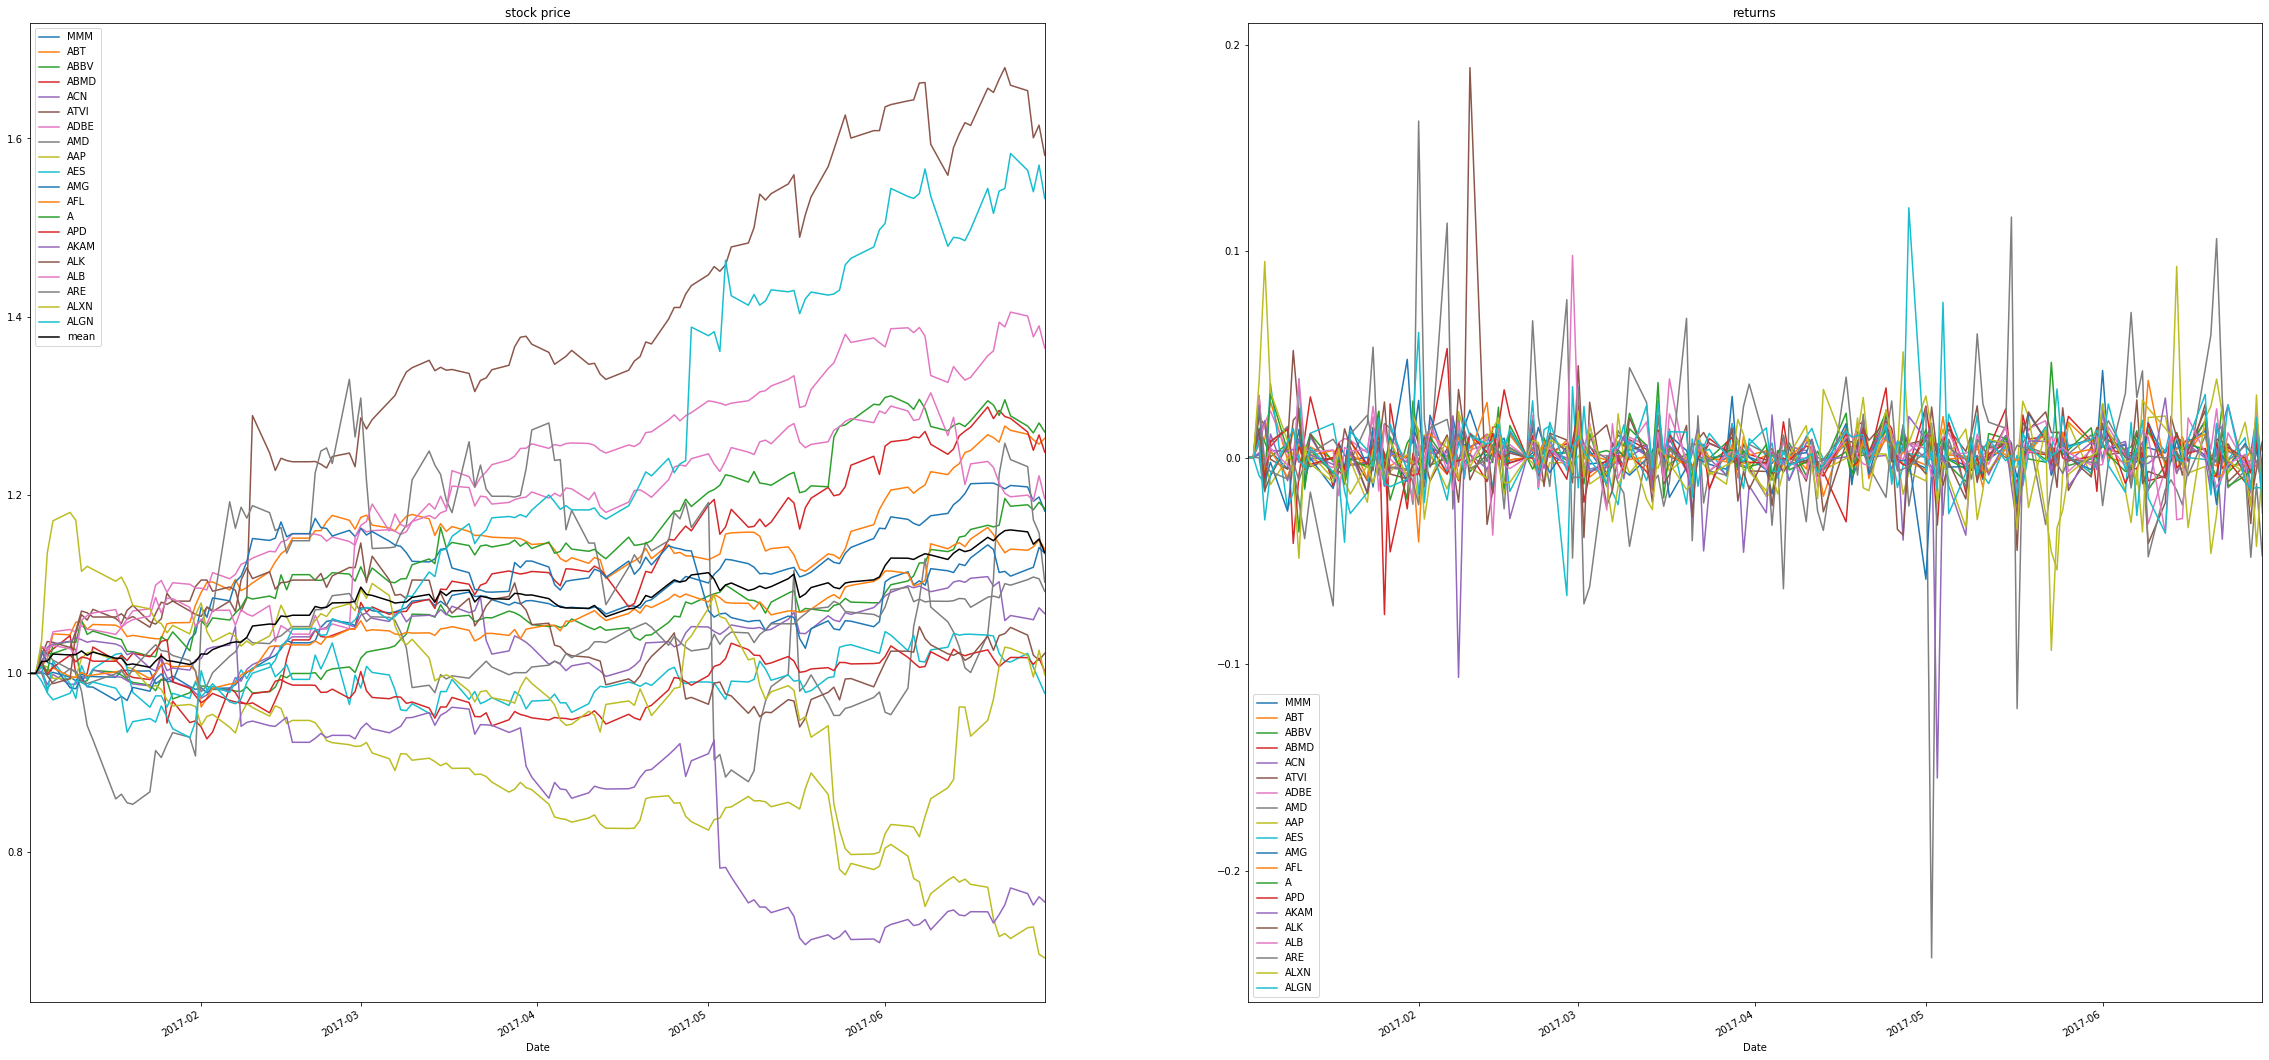

In [6]:
delete_nans_graph('data/dirty_data.csv', 'data/clean_data.csv')
plot_example_returns('data/clean_data.csv', N)

In [53]:
#run is a run of the network, used in main
def run(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 1, 32, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    #init
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=inp_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    #Conv1D => 1D Convolution (Schaut nach Mustern)
    #mit filters = Anzahl Weight Functions, kernel_size = Anzahl simultan betrachteter Felder, 
    #relu = 0 für value<0 sonst linear
    
    model.add(layers.Dropout(0.5))
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

Function to check internal goodness - predicted values vs actual measured values used for training

In [63]:
def internal_goodness(model, x_new, y_new):
    y_pred = model.predict(x_new)
    #model.predict nimmt x-werte und gibt die predicteten y-werte zurück
    plt.scatter(y_new, y_pred)

Function to check external goodness - predicted values for future data vs actual future data

In [99]:
def external_goodness(model, x_new, y_new):
    y_pred = model.predict(x_new)
    color =  ["r", "b", "g"]
    for i in range(3):
        plt.plot(y_new[i],c=color[i], label = 'true')
        plt.plot(y_pred[i], c=color[i], linestyle='--', label = 'pred')
    plt.legend()

Die Funktion get_data_subsets unterteilt die Matrix in eine Matrix der Dimension dur x N (Zeitfenster x Stocks) und korrespondierender Vektor für den Tag darauf (dur=1 x stocks). Jedes Matrix-Vektor Paar stellt einen Input plus Target Output(Label, Lösung) dar.

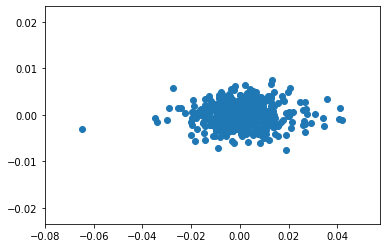

In [100]:
internal_goodness(model,x_test,y_test)

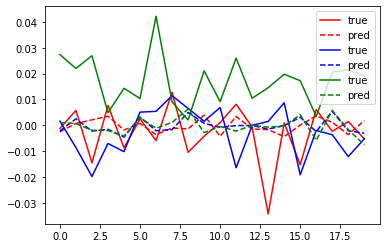

In [101]:
external_goodness(model,x_test,y_test)

In [108]:
def zwexternal_goodness(model,x_new,y_new):
    y_pred = model.predict(x_new)
    
    print(y_new.shape)
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            p= y_pred[i,j] > 0
            n = y_new[i,j] > 0
            if n==p:
                count +=1
    print(count/len(y_pred)/len(y_pred[0]))
zwexternal_goodness(model,x_test,y_test)

(23, 20)
0.532608695652174


In [68]:
# def model(x_train, y_train, x_test, y_test):
def main(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """
    N = input_df.shape[1]
    D = input_df.shape[0]
    inp_shape=(dur,N)
    
    
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train) 
    x_test,y_test = get_data_subsets(test)
    model = run(x_train, y_train, x_test, y_test, inp_shape)
    
    """für Dimensions-tests"""
    #print(x_train.shape)
    #print(y_train.shape)
    #print(test.shape)
    #print(x_test.shape)
    #print(y_test.shape)
    return model,x_test,y_test
    
model,x_test,y_test = main(returns, 30, 100)

100
70
53
23
Epoch 1/32
70/70 [==============================] - 1s 10ms/step - loss: 1.8645e-04 - mse: 1.8645e-04 - mae: 0.0100
Epoch 2/32
70/70 [==============================] - 0s 436us/step - loss: 1.6025e-04 - mse: 1.6025e-04 - mae: 0.0090
Epoch 3/32
70/70 [==============================] - 0s 482us/step - loss: 1.5362e-04 - mse: 1.5362e-04 - mae: 0.0087
Epoch 4/32
70/70 [==============================] - 0s 449us/step - loss: 1.4560e-04 - mse: 1.4560e-04 - mae: 0.0084
Epoch 5/32
70/70 [==============================] - 0s 427us/step - loss: 1.4319e-04 - mse: 1.4319e-04 - mae: 0.0083
Epoch 6/32
70/70 [==============================] - 0s 461us/step - loss: 1.4311e-04 - mse: 1.4311e-04 - mae: 0.0083
Epoch 7/32
70/70 [==============================] - 0s 440us/step - loss: 1.4186e-04 - mse: 1.4186e-04 - mae: 0.0083
Epoch 8/32
70/70 [==============================] - 0s 408us/step - loss: 1.4220e-04 - mse: 1.4220e-04 - mae: 0.0083
Epoch 9/32
70/70 [==============================] - 